# Quadratic Discriminant Analysis - Regularized QDA

# I) Description

The training function takes as input:
- Xapp (n x p)
- zapp (n x K)
- mprior (K x p)
- df_exp (1)
- Sprior (p x p x K)
- df_cov (1)

This training function returns:
- pi (1 x K)
- mu (K x p) 
- Sig (p x p x K)

In [1]:
import datapackage
import pandas as pd
import numpy as np 
from numpy.linalg import inv
import random
from scipy.stats import multivariate_normal
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# II) Function definitions

## Training Function

In [2]:
def trainingFunction (Xapp, zapp, mprior, df_exp, Sprior, df_cov):
    
    #Récupération du nombre de samples 
    n = Xapp.shape[0]

    #Nombre de features dans le dataset
    p = Xapp.shape[1]
    
    #On récupère dans un dictionnaire le nombre d'occurences de chaque classe (pour nous donner une idée)
    counts = zapp.value_counts().to_dict()
    #print(counts)
    
    #tableau des différentes classes qui va nous servir d'index - ce tableau est trié
    countsValues = np.copy(np.sort(np.array(list(counts.keys()))))

    #Nombre de classes dans notre dataset
    k = len(counts)
    
    #Initialisation des différentes variables retournées par la fonction 

    #Initialisation et calcul de pi
    pi = np.array(list(counts.values()))/n

    #Initialisation de mu 
    mu = np.zeros((k,p))
    
    #Initialisation de Sig
    Sig = np.zeros((k, p, p))
    
    #On filtre par rapport à la classe et on exclut la dernière colonne "class" puis on effectue la somme
    
    for class_k, class_count in counts.items():
        #Calcul de mu(kxp), sur la ligne, on a nos classes 

        class_k_index = np.where(countsValues==class_k)[0][0]
        
        #Calcul de mu 
        mu[class_k_index] = (Xapp[zapp==class_k].iloc[:, 0:p].sum(axis = 0, skipna = True) + df_exp * mprior[class_k_index][:]) / (class_count + df_exp)
        # mu devrait être bon normalement

        #Calcul de Sig(Kxpxp)
    
        #On calcul x(i) - mu(k) pour les samples issus de la classe k
        XappBis = (Xapp[zapp==class_k].iloc[:, 0:p] - mu[class_k_index]).to_numpy()
    
        #Initialisation de B --> matrice de pxp
        B = np.zeros((p,p))
        
        #On boucle sur l'ensemble des samples de la classe K
        for i in range(0, class_count):
        
            #On créé un tableau à partir du vecteur pour permettre la transposée (sinon la transposée d'un vecteur reste lui-même)
            XappBisArray = np.reshape(XappBis[i],(-1,p))
        
            #Pour chaque sample i, on somme le produit des vecteurs : 64x1 * 1x64 = 64x64 (les dimensions résultantes)
            B = B + np.matmul(np.transpose(XappBisArray), XappBisArray)
    
        #Correspond au calcul du deuxième terme de la somme de Sig
        subMu = mu[class_k_index] - mprior[class_k_index][:]
    
        #Comme tout à l'heure, on transforme en tableau pour pouvoir effectuer la multiplication (même démarche)
        subMuArray = np.reshape(subMu, (-1,p))
        subMuArrayMul = np.matmul(np.transpose(subMuArray), subMuArray)

        #On calcule Sig pour la classe k
        Sig[class_k_index] = (B + df_exp * subMuArrayMul + inv(Sprior[class_k_index])) / (class_count + df_cov + 2 + p )
       
    #Return pi, mu and Sig
    return pi, mu, Sig, countsValues

## Evaluation function

In [3]:
def evaluationFunction(Xtst, pi, mu, sig, countsValues):
    
    #Dans Xtst, on a n samples avec une dimension égale à p 
    
    #Récupération du nombre de samples et de features
    n = Xtst.shape[0]

    #Nombre de features dans le dataset
    p = Xtst.shape[1]
    
    prob = np.zeros((n, len(counts)))
    
    if(isinstance(countsValues[1], str)):
        pred = np.empty(n, dtype='object')
    else:
        pred = np.zeros((n, 1))

    #Parcours de l'ensemble des samples 
    for i in range(0, n):
        #Pour chaque sample on boucle sur l'ensemble des classes
        for k, v in counts.items():
                  
            class_k_index = np.where(countsValues==k)[0][0]
            
            prob[i, class_k_index] = multivariate_normal.pdf(Xtst.iloc[i, 0:p], mu[class_k_index], sig[class_k_index]) * pi[class_k_index]
        
        denominateur = sum(prob[i,:])
        prob[i,:] /= denominateur
        pred[i] = countsValues[prob[i][:].argmax()]
    
    return(prob, pred)

## Accuracy function

In [4]:
def getAccuracy(pred,ztst):
    errors = 0
    for i in range(len(ztst)) :
        if pred[i] != ztst[i]:
            errors += 1

    correct = len(ztst) - errors
    #print("Accuracy : " + str((correct/len(ztst))*100) + "%")
    return (correct/len(ztst))*100

## CrossValidation function

In [5]:
#Fonction de cross-validation pour le choix des hyperparamètres scalaires df_exp et df_cov
#On cherche le meilleur couple de paramètres df_exp et df_cov possible

#nTrain est le nombre de données que l'on prend en entrainement 
#df est le dataset

def crossValidation(X, z, mprior, Sprior, df_exp, df_cov, K=5):

    #Nombre de prédicteurs
    n = X.shape[0]
    
    setClasses = set(z)
    
    #Espace de variation des paramètres
    # df_exp = np.geomspace(0.01, 100.0, num= shrVariation)
    # df_cov = np.linspace(p, p+1000, num= dfVariation)
    
    for i in range(len(df_cov)):
        df_cov[i] = int(df_cov[i])
    
    print("Shrinkage parameters to be tested:")
    print(df_exp)
    print()
    print("Degrees of freedom:")
    print(df_cov)

    #Initialisation 
    df_exp_minError = df_exp[0]
    df_cov_minError = df_cov[0]
    
    print(df_exp_minError)
    print(df_cov_minError)
    # np.random.seed(0)
    
    reshuffle = True
    while reshuffle:
        reshuffle=False
        folds = np.random.choice(np.linspace(0, K, K+1), size = n, replace=True)
        for k in range(0,K+1):
            ztst = np.array(z.iloc[folds == k])
            for cl in setClasses:
                if cl not in ztst:
                    reshuffle=True
                    #print("Regenerating cross-validation folds...")
                    break
    accuracyArray = np.full((len(df_exp), len(df_cov)),0.0)
    
    maxAccuracy = 0
    
    #Pour chaque couple de paramètre possible, on évalue la précision
    for i in range(len(df_exp)):   
        for j in range(len(df_cov)):
            
            for k in range(0, K+1):

                Xtrain = X.iloc[folds != k,]
                Xtest = X.iloc[folds == k,]
                zapp = z.iloc[folds != k]
                ztst = np.array(z.iloc[folds == k])
                
                #On train le modèle 
                (pi, mu, Sig, countsValues) = trainingFunction(Xtrain, zapp, mprior, df_exp[i], Sprior, df_cov[j])
        
                #On évalue en fonction des données test
                (prob, pred) = evaluationFunction(Xtest, pi, mu, Sig, countsValues)
                
                #La précision est meilleure avec ce couple de paramètres
                accuracy = getAccuracy(pred, ztst)
                
                accuracyArray[i][j] += accuracy
                # print("Accuracy for fold " + str(k) + " : " + str(accuracy))
            
            accuracyArray[i][j] = float(accuracyArray[i][j])/(K+1)
            
            if accuracyArray[i][j] > maxAccuracy:
                maxAccuracy = accuracyArray[i][j]
                df_exp_minError = df_exp[i]
                df_cov_minError = df_cov[j]
                
    print("Accuracy array with wishart parameter as abscissa and shrinkage parameter as ordinate")
    print(accuracyArray)
            
    return (df_exp_minError, df_cov_minError)

# III) Début du code

## Importation des datasets

In [6]:
#First dataset optdigits
data_url = 'https://datahub.io/machine-learning/optdigits/datapackage.json'
# to load Data Package into storage
package = datapackage.Package(data_url)
# to load only tabular data
resources = package.resources
for resource in resources:
    if resource.tabular:
        dfOptDigits = pd.read_csv(resource.descriptor['path'])
        
#Second dataset page-blocks     
data_url = 'https://datahub.io/machine-learning/page-blocks/datapackage.json'
# to load Data Package into storage
package = datapackage.Package(data_url)
# to load only tabular data
resources = package.resources
for resource in resources:
    if resource.tabular:
        dfPageBlocks = pd.read_csv(resource.descriptor['path']) 


#Third dataset satimage
data_url = 'https://datahub.io/machine-learning/satimage/datapackage.json'
# to load Data Package into storage
package = datapackage.Package(data_url)
# to load only tabular data
resources = package.resources
for resource in resources:
    if resource.tabular:
        dfSatimage = pd.read_csv(resource.descriptor['path'])
        
#Fourth dataset segment
data_url = 'https://datahub.io/machine-learning/segment/datapackage.json'
# to load Data Package into storage
package = datapackage.Package(data_url)
# to load only tabular data
resources = package.resources
for resource in resources:
    if resource.tabular:
        dfSegment = pd.read_csv(resource.descriptor['path'])

In [7]:
# randomly redistributes data making sure that all classes can be present in all K cross-validation folds
def selectDataSubset(df,share,K):
    reshuffle=True
    errCount = 0
    shuffled = 0
    while reshuffle:
        if errCount>100: #100 is an arbitrary value
            raise ValueError("All classes cannot be represented in all cross-validation folds, K should be lowered.")
        reshuffle=False
        
        shuffled = df.sample(frac=share)
        
        z = shuffled['class']
        
        setClasses = set(z)
        
        # print(znew)

        counts = z.value_counts().to_dict()
        for cl in setClasses:
            try:
                if counts[cl] < K+2:
                    reshuffle = True
                    #print("Reshuffling classes...")
                    errCount += 1
                    break
            except KeyError:
                reshuffle = True
                #print("Reshuffling classes...")
                errCount += 1
                break
    return shuffled

## Traitement des datasets

In [10]:
#datasets = ['dfOptDigits', 'dfPageBlocks', 'dfSatimage', 'dfSegment']
# nTrainDatasets = [3823, 3823, 3823, 1500]
datasets = ['dfOptDigits', 'dfSatimage', 'dfSegment', 'dfPageBlocks']

sharesReg = {}
sharesNorm = {}

shareOfTrainData = 0.75
subShareTrainData = [0.1, 0.2, 0.5, 0.7, 1]

hyperdf_exp = {'dfOptDigits':np.geomspace(0.01,10,num=5),
               'dfPageBlocks':np.geomspace(0.01,10,num=4),
               'dfSatimage':np.geomspace(0.01,10,num=5),
               'dfSegment':np.geomspace(0.01,10,num=5)}

hyperdf_cov = {'dfOptDigits':np.linspace(0,500,dtype=np.int32,num=5),
               'dfPageBlocks':np.linspace(0,500,dtype=np.int32,num=4),
               'dfSatimage':np.linspace(0,500,dtype=np.int32,num=5),
               'dfSegment':np.linspace(0,500,dtype=np.int32,num=5)}

for i in range(0, len(datasets)):
    
    print("__________________________________________")
    print("Current dataset is: " + datasets[i])   
    df = eval(datasets[i])
    
    sharesReg[datasets[i]] = []
    sharesNorm[datasets[i]] = []
    
    # we randomize the dataset in order to avoid overfitting on the same data
    df = df.sample(frac=1)
    
    # we consider that all classes will be represented in both shares of the dataset, even for page-blocks
    n = df.shape[0]
    
    nTrain = int(n*shareOfTrainData)
    print("Total number of training data : " + str(nTrain))
    
    dfTrain = df.iloc[:nTrain, :]
    dfTest = df.iloc[nTrain:, :]
    
    XTest = dfTest.drop(['class'],axis=1)
    ztst = np.array(dfTest['class'])
    
    if datasets[i] == 'dfPageBlocks': # for numerical stability
        XTest = XTest.div(1000)
    
    #zapp = z.iloc[:nTrain]
    #ztst = np.array(z.iloc[nTrain:])
    
    for share in subShareTrainData:
        
        crossValK = 5
        
        dfapp = selectDataSubset(dfTrain,share,crossValK)
        
        XTrain = dfapp.drop(['class'] ,axis=1)
        zapp = dfapp["class"] 
        p = XTrain.shape[1]
        n = XTrain.shape[0]
        
        if datasets[i] == 'dfPageBlocks': # for numerical stability
            XTrain = XTrain.div(1000)
        
        print("Share of data to train : "+str(share*100)+"%")
        
        print("Training with "+str(n)+" examples")
        
        #Initialisation des paramètres 
        counts = zapp.value_counts().to_dict()

        k = len(counts)

        mprior = np.full((k,p),0)

        Sprior = np.empty((k,p,p))

        #Essayer d'initialiser une Sprior tel que le déterminant est différent de 0 
        for j in range(0, k):
            Sprior[j] = np.identity(p)
        
        #Hyperparameters cross-validation initialization
        df_exp = hyperdf_exp[datasets[i]]
        df_cov = hyperdf_cov[datasets[i]] + p

        (df_exp_minError, df_cov_minError) = crossValidation(XTrain, zapp, mprior, Sprior, df_exp, df_cov, crossValK)
        print("Chosen parameters before tuning:")
        print(df_exp_minError, df_cov_minError)
        
        #Tuning parameters
        tuningParameter = 0.4
        df_exp = np.geomspace(df_exp_minError-tuningParameter*df_exp_minError, df_exp_minError+tuningParameter*df_exp_minError, num=5)
        if ((df_cov_minError - tuningParameter * df_cov_minError)<=p):
            df_cov = np.linspace(p,df_cov_minError+tuningParameter*df_cov_minError,dtype=np.int32,num=5)
        else:
            df_cov = np.linspace(df_cov_minError-tuningParameter*df_cov_minError,df_cov_minError+tuningParameter*df_cov_minError,dtype=np.int32,num=5)
        (df_exp_minError, df_cov_minError) = crossValidation(XTrain, zapp, mprior, Sprior, df_exp, df_cov, crossValK)
        print("Chosen parameters after tuning:")
        print(df_exp_minError, df_cov_minError)

        #Appel de la fonction de train
        (pi, mu, Sig, countsValues) = trainingFunction(XTrain, zapp, mprior, df_exp_minError, Sprior, df_cov_minError)

        #Appel de la fonction d'évaluation
        (prob, pred) = evaluationFunction(XTest, pi, mu, Sig, countsValues)

        # classification with simple QDA
        clf = QDA()
        clf.fit(np.array(XTrain), np.array(zapp))
        predictions = clf.predict(np.array(XTest))
        print("Accuracy with QDA: ")
        accurQDA = getAccuracy(predictions, ztst)
        print(accurQDA)
        print("Accuracy with Regularized QDA: ")
        accurRegul = getAccuracy(pred, ztst)
        print(accurRegul)

        print("Classification report with QDA: ")
        print(classification_report(ztst,predictions))
        print()
        print("Classification report with Regularized QDA: ")
        print(classification_report(ztst,pred))
        
        sharesReg[datasets[i]].append(accurRegul)
        sharesNorm[datasets[i]].append(accurQDA)
        # data to be plotted afterwards

__________________________________________
Current dataset is: dfOptDigits
Total number of training data : 4215
Share of data to train : 10.0%
Training with 422 examples
Shrinkage parameters to be tested:
[ 0.01        0.05623413  0.31622777  1.77827941 10.        ]

Degrees of freedom:
[ 64 189 314 439 564]
0.01
64


C:\Users\Anathan\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


Accuracy array with wishart parameter as abscissa and shrinkage parameter as ordinate
[[13.12236014  9.01523971  9.01523971  8.15199184  8.15199184]
 [13.89340568  9.24355021  9.01523971  8.15199184  8.15199184]
 [14.1156279   9.56406303  9.01523971  8.47250466  8.15199184]
 [14.1156279   9.56406303  9.01523971  8.47250466  8.15199184]
 [14.1156279   9.56406303  9.01523971  8.47250466  8.15199184]]
Chosen parameters before tuning:
0.31622776601683794 64
Shrinkage parameters to be tested:
[0.18973666 0.2345014  0.28982753 0.35820681 0.44271887]

Degrees of freedom:
[64 70 76 83 89]
0.18973665961010275
64
Accuracy array with wishart parameter as abscissa and shrinkage parameter as ordinate
[[15.15598756 14.43925984 14.18284959 13.92643933 13.48509206]
 [15.15598756 14.43925984 14.18284959 13.92643933 13.48509206]
 [15.15598756 14.43925984 14.18284959 13.92643933 13.48509206]
 [15.15598756 14.43925984 14.18284959 13.92643933 13.48509206]
 [15.15598756 14.43925984 14.18284959 13.92643933 1

C:\Users\Anathan\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Anathan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy with QDA: 
10.320284697508896
Accuracy with Regularized QDA: 
39.50177935943061
Classification report with QDA: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       143
           1       0.17      0.01      0.01       156
           2       0.00      0.00      0.00       136
           3       0.50      0.01      0.01       136
           4       1.00      0.03      0.06       136
           5       0.10      1.00      0.18       139
           6       0.00      0.00      0.00       133
           7       0.00      0.00      0.00       150
           8       0.00      0.00      0.00       138
           9       0.00      0.00      0.00       138

    accuracy                           0.10      1405
   macro avg       0.18      0.10      0.03      1405
weighted avg       0.17      0.10      0.03      1405


Classification report with Regularized QDA: 
              precision    recall  f1-score   support

           0      

C:\Users\Anathan\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


Accuracy array with wishart parameter as abscissa and shrinkage parameter as ordinate
[[86.18286939 81.78034328 74.47479257 65.91212974 58.38921307]
 [86.31271616 81.92995102 74.82614172 66.49253106 58.98694746]
 [86.79142647 81.94567603 75.70410578 67.58791595 60.78257807]
 [86.42439791 82.06057295 75.81904831 67.81940859 61.27862098]
 [86.42439791 81.94563043 76.04975368 67.70285848 61.27862098]]
Chosen parameters before tuning:
0.31622776601683794 64
Shrinkage parameters to be tested:
[0.18973666 0.2345014  0.28982753 0.35820681 0.44271887]

Degrees of freedom:
[64 70 76 83 89]
0.18973665961010275
64
Accuracy array with wishart parameter as abscissa and shrinkage parameter as ordinate
[[86.67888231 86.08278005 85.86055783 85.74944672 85.74944672]
 [86.5677712  85.97166894 85.97166894 85.61394536 85.61394536]
 [86.5677712  85.97166894 85.83616759 85.7296861  85.7296861 ]
 [86.43226985 85.97166894 85.83616759 85.61394536 85.61394536]
 [86.43226985 86.08740968 85.83616759 85.72505647 8

C:\Users\Anathan\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy with QDA: 
69.82206405693951
Accuracy with Regularized QDA: 
90.74733096085409
Classification report with QDA: 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       143
           1       0.80      0.45      0.58       156
           2       0.94      0.89      0.91       136
           3       0.98      0.38      0.55       136
           4       0.88      0.77      0.82       136
           5       0.94      0.78      0.85       139
           6       0.92      0.36      0.52       133
           7       0.95      0.87      0.91       150
           8       0.29      0.99      0.45       138
           9       0.70      0.49      0.58       138

    accuracy                           0.70      1405
   macro avg       0.84      0.70      0.72      1405
weighted avg       0.84      0.70      0.72      1405


Classification report with Regularized QDA: 
              precision    recall  f1-score   support

           0       

C:\Users\Anathan\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


Accuracy array with wishart parameter as abscissa and shrinkage parameter as ordinate
[[95.13013563 94.976691   94.88528378 94.7041456  94.51705026]
 [95.13013563 94.976691   94.88528378 94.7041456  94.51705026]
 [95.13013563 94.976691   94.84095754 94.7041456  94.51705026]
 [95.13013563 94.88541641 94.79125445 94.70139087 94.51705026]
 [94.98765668 94.83833543 94.8382028  94.69847859 94.51292689]]
Chosen parameters before tuning:
0.01 64
Shrinkage parameters to be tested:
[0.006      0.00741559 0.00916515 0.01132749 0.014     ]

Degrees of freedom:
[64 70 76 83 89]
0.006000000000000003
64
Accuracy array with wishart parameter as abscissa and shrinkage parameter as ordinate
[[95.63444479 95.58865724 95.44839292 95.44839292 95.44839292]
 [95.63444479 95.58865724 95.44839292 95.44839292 95.44839292]
 [95.63444479 95.58865724 95.44839292 95.44839292 95.44839292]
 [95.63444479 95.58865724 95.44839292 95.44839292 95.44839292]
 [95.63444479 95.53934758 95.44839292 95.44839292 95.44839292]]
C

C:\Users\Anathan\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy with QDA: 
72.59786476868328
Accuracy with Regularized QDA: 
96.37010676156584
Classification report with QDA: 
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       143
           1       0.91      0.52      0.66       156
           2       0.99      0.80      0.89       136
           3       0.93      0.42      0.58       136
           4       0.96      0.38      0.54       136
           5       0.93      0.60      0.73       139
           6       0.88      1.00      0.93       133
           7       0.66      0.99      0.79       150
           8       0.35      0.98      0.51       138
           9       0.89      0.59      0.71       138

    accuracy                           0.73      1405
   macro avg       0.85      0.73      0.73      1405
weighted avg       0.85      0.73      0.73      1405


Classification report with Regularized QDA: 
              precision    recall  f1-score   support

           0       

C:\Users\Anathan\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


Accuracy array with wishart parameter as abscissa and shrinkage parameter as ordinate
[[96.35144225 96.11359719 96.11395074 96.07944418 95.84360165]
 [96.35144225 96.18150388 96.11395074 96.07944418 95.84360165]
 [96.3169357  96.21490401 96.04761253 95.97705895 95.81006711]
 [96.18301845 96.08409571 95.94676988 95.87811031 95.6783148 ]
 [96.08420422 96.01511061 95.94676988 95.91194449 95.81142526]]
Chosen parameters before tuning:
0.01 64
Shrinkage parameters to be tested:
[0.006      0.00741559 0.00916515 0.01132749 0.014     ]

Degrees of freedom:
[64 70 76 83 89]
0.006000000000000003
64
Accuracy array with wishart parameter as abscissa and shrinkage parameter as ordinate
[[96.04630364 96.04630364 96.04630364 96.04630364 96.04630364]
 [96.04630364 96.04630364 96.04630364 96.04630364 96.04630364]
 [96.04630364 96.04630364 96.04630364 96.04630364 96.04630364]
 [96.04630364 96.04630364 96.04630364 96.04630364 96.04630364]
 [96.04630364 96.04630364 96.04630364 96.04630364 96.04630364]]
C

C:\Users\Anathan\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy with QDA: 
79.21708185053382
Accuracy with Regularized QDA: 
97.08185053380784
Classification report with QDA: 
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       143
           1       0.93      0.64      0.76       156
           2       0.97      0.95      0.96       136
           3       0.94      0.74      0.83       136
           4       1.00      0.32      0.48       136
           5       0.96      0.78      0.86       139
           6       0.96      0.95      0.96       133
           7       0.65      0.99      0.79       150
           8       0.49      0.97      0.65       138
           9       0.89      0.57      0.70       138

    accuracy                           0.79      1405
   macro avg       0.86      0.79      0.79      1405
weighted avg       0.86      0.79      0.79      1405


Classification report with Regularized QDA: 
              precision    recall  f1-score   support

           0       

C:\Users\Anathan\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


Accuracy array with wishart parameter as abscissa and shrinkage parameter as ordinate
[[96.51029348 96.46231747 96.43857578 96.3403615  96.31661981]
 [96.51029348 96.46231747 96.43857578 96.3403615  96.31661981]
 [96.48530597 96.46231747 96.46231747 96.3403615  96.31661981]
 [96.48530597 96.46231747 96.41445614 96.34129143 96.29400924]
 [96.41558727 96.48585796 96.41445614 96.38822282 96.29476243]]
Chosen parameters before tuning:
0.01 64
Shrinkage parameters to be tested:
[0.006      0.00741559 0.00916515 0.01132749 0.014     ]

Degrees of freedom:
[64 70 76 83 89]
0.006000000000000003
64
Accuracy array with wishart parameter as abscissa and shrinkage parameter as ordinate
[[96.46530662 96.46523879 96.46523879 96.48898048 96.48898048]
 [96.46530662 96.46523879 96.46523879 96.48898048 96.48898048]
 [96.46530662 96.46523879 96.46523879 96.48898048 96.48898048]
 [96.46530662 96.46523879 96.46523879 96.48898048 96.48898048]
 [96.46530662 96.46523879 96.46523879 96.48898048 96.48898048]]
C

C:\Users\Anathan\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy with QDA: 
74.87544483985765
Accuracy with Regularized QDA: 
97.01067615658363
Classification report with QDA: 
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       143
           1       0.92      0.72      0.81       156
           2       1.00      0.68      0.81       136
           3       0.84      0.52      0.64       136
           4       0.97      0.43      0.60       136
           5       0.94      0.58      0.72       139
           6       0.97      1.00      0.99       133
           7       0.81      0.97      0.88       150
           8       0.35      0.99      0.51       138
           9       0.92      0.57      0.70       138

    accuracy                           0.75      1405
   macro avg       0.86      0.75      0.76      1405
weighted avg       0.86      0.75      0.76      1405


Classification report with Regularized QDA: 
              precision    recall  f1-score   support

           0       

C:\Users\Anathan\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


Accuracy array with wishart parameter as abscissa and shrinkage parameter as ordinate
[[84.16617598 83.24264057 82.93288442 82.28473627 81.87120244]
 [84.40427122 83.01115909 82.51621775 82.05325479 81.63972096]
 [84.17278974 83.05745539 83.13368763 82.23843998 81.87781619]
 [84.55877814 83.03209077 83.12394104 82.64536005 82.06300138]
 [84.36458868 82.60641983 81.92281239 81.82360604 81.00315212]]
Chosen parameters before tuning:
1.7782794100389228 36
Shrinkage parameters to be tested:
[1.06696765 1.3186983  1.62982    2.01434493 2.48959117]

Degrees of freedom:
[36 39 43 46 50]
1.0669676460233535
36
Accuracy array with wishart parameter as abscissa and shrinkage parameter as ordinate
[[83.8347239  83.8347239  83.56149986 83.56149986 83.28827581]
 [83.8347239  83.8347239  83.8347239  83.8347239  83.28827581]
 [83.56149986 83.56149986 83.56149986 83.56149986 83.28827581]
 [83.74876577 83.74876577 83.74876577 83.69199195 83.69199195]
 [83.96521599 83.96521599 83.96521599 83.69199195 83.

C:\Users\Anathan\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


Accuracy array with wishart parameter as abscissa and shrinkage parameter as ordinate
[[85.8913215  84.0917064  81.83112101 79.21849778 77.88606779]
 [85.8913215  84.64726196 82.38667656 79.77405333 78.44162334]
 [85.8913215  84.64726196 82.38667656 79.77405333 78.44162334]
 [85.8913215  84.64726196 82.38667656 79.77405333 78.44162334]
 [85.8913215  84.64726196 81.74565092 79.77405333 78.44162334]]
Chosen parameters before tuning:
0.01 19
Shrinkage parameters to be tested:
[0.006      0.00741559 0.00916515 0.01132749 0.014     ]

Degrees of freedom:
[19 20 22 24 26]
0.006000000000000003
19
Accuracy array with wishart parameter as abscissa and shrinkage parameter as ordinate
[[86.32844593 86.32844593 86.32844593 86.32844593 86.83349643]
 [87.08602168 87.08602168 87.08602168 86.32844593 86.32844593]
 [87.08602168 87.08602168 87.08602168 87.08602168 87.08602168]
 [87.08602168 87.08602168 87.08602168 87.08602168 87.08602168]
 [87.08602168 87.08602168 87.08602168 87.08602168 87.08602168]]
C

C:\Users\Anathan\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Anathan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy with QDA: 
40.31141868512111
Accuracy with Regularized QDA: 
83.39100346020761
Classification report with QDA: 
              precision    recall  f1-score   support

   brickface       0.69      0.78      0.73        85
      cement       0.00      0.00      0.00        79
     foliage       0.40      0.96      0.57        85
       grass       1.00      0.06      0.11        70
        path       0.29      1.00      0.45        80
         sky       0.00      0.00      0.00       101
      window       1.00      0.01      0.03        78

    accuracy                           0.40       578
   macro avg       0.48      0.40      0.27       578
weighted avg       0.46      0.40      0.27       578


Classification report with Regularized QDA: 
              precision    recall  f1-score   support

   brickface       0.85      0.94      0.89        85
      cement       0.65      0.81      0.72        79
     foliage       0.70      0.80      0.75        85
       grass       

C:\Users\Anathan\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


Accuracy array with wishart parameter as abscissa and shrinkage parameter as ordinate
[[87.06711733 87.0391634  86.39038537 85.87330986 86.12583511]
 [87.06711733 87.34780538 86.39038537 85.87330986 86.12583511]
 [86.74660451 87.34780538 86.69902735 85.87330986 86.12583511]
 [86.74660451 87.34780538 86.69902735 85.87330986 86.12583511]
 [86.74660451 87.34780538 86.69902735 85.55279704 86.12583511]]
Chosen parameters before tuning:
0.05623413251903491 144
Shrinkage parameters to be tested:
[0.03374048 0.0417009  0.05153943 0.06369918 0.07872779]

Degrees of freedom:
[ 86 115 144 172 201]
0.033740479511420944
86
Accuracy array with wishart parameter as abscissa and shrinkage parameter as ordinate
[[87.89762471 87.95751047 87.02213632 87.02213632 86.97327349]
 [87.89762471 87.95751047 87.02213632 87.02213632 86.97327349]
 [87.89762471 87.95751047 87.02213632 87.02213632 86.97327349]
 [87.89762471 87.95751047 87.02213632 86.72451727 86.97327349]
 [87.89762471 87.95751047 87.02213632 86.724

C:\Users\Anathan\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy with QDA: 
67.82006920415225
Accuracy with Regularized QDA: 
87.88927335640139
Classification report with QDA: 
              precision    recall  f1-score   support

   brickface       0.83      0.56      0.67        85
      cement       0.57      0.54      0.56        79
     foliage       0.53      0.31      0.39        85
       grass       0.99      0.99      0.99        70
        path       0.54      1.00      0.70        80
         sky       1.00      1.00      1.00       101
      window       0.32      0.32      0.32        78

    accuracy                           0.68       578
   macro avg       0.68      0.67      0.66       578
weighted avg       0.69      0.68      0.67       578


Classification report with Regularized QDA: 
              precision    recall  f1-score   support

   brickface       0.94      0.99      0.97        85
      cement       0.79      0.90      0.84        79
     foliage       0.90      0.54      0.68        85
       grass       

C:\Users\Anathan\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


Accuracy array with wishart parameter as abscissa and shrinkage parameter as ordinate
[[91.08467351 92.32117303 92.19338255 92.33025591 92.90373857]
 [91.08467351 92.45240663 92.19338255 92.33025591 92.90373857]
 [91.08467351 92.45240663 92.19338255 92.33025591 92.90373857]
 [91.08467351 92.45240663 92.19338255 92.33025591 92.90373857]
 [91.08467351 92.45240663 92.19338255 92.33025591 92.90373857]]
Chosen parameters before tuning:
0.01 519
Shrinkage parameters to be tested:
[0.006      0.00741559 0.00916515 0.01132749 0.014     ]

Degrees of freedom:
[311 415 519 622 726]
0.006000000000000003
311
Accuracy array with wishart parameter as abscissa and shrinkage parameter as ordinate
[[92.60777676 92.60777676 92.13905624 92.3689413  92.3689413 ]
 [92.60777676 92.60777676 92.13905624 92.3689413  92.3689413 ]
 [92.60777676 92.60777676 92.13905624 92.3689413  92.3689413 ]
 [92.60777676 92.60777676 92.13905624 92.3689413  92.3689413 ]
 [92.60777676 92.60777676 92.13905624 92.3689413  92.36894

C:\Users\Anathan\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy with QDA: 
65.7439446366782
Accuracy with Regularized QDA: 
92.73356401384083
Classification report with QDA: 
              precision    recall  f1-score   support

   brickface       0.71      0.85      0.77        85
      cement       0.67      0.03      0.05        79
     foliage       0.38      0.76      0.51        85
       grass       0.93      0.99      0.96        70
        path       0.91      0.75      0.82        80
         sky       0.78      1.00      0.87       101
      window       0.31      0.14      0.19        78

    accuracy                           0.66       578
   macro avg       0.67      0.64      0.60       578
weighted avg       0.67      0.66      0.60       578


Classification report with Regularized QDA: 
              precision    recall  f1-score   support

   brickface       0.98      0.99      0.98        85
      cement       0.84      0.92      0.88        79
     foliage       0.86      0.87      0.87        85
       grass       1

C:\Users\Anathan\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


Accuracy array with wishart parameter as abscissa and shrinkage parameter as ordinate
[[89.06084506 91.23418601 91.57727013 91.67279077 91.59368488]
 [89.06084506 91.23418601 91.57727013 91.67279077 91.59368488]
 [89.06084506 91.23418601 91.57727013 91.67279077 91.59368488]
 [89.06084506 91.23418601 91.57727013 91.67279077 91.59368488]
 [89.06084506 91.23418601 91.57727013 91.67279077 91.67578668]]
Chosen parameters before tuning:
10.0 519
Shrinkage parameters to be tested:
[ 6.          7.4155855   9.16515139 11.32749396 14.        ]

Degrees of freedom:
[311 415 519 622 726]
6.0
311
Accuracy array with wishart parameter as abscissa and shrinkage parameter as ordinate
[[91.8270813  91.81328017 91.88488856 91.59513056 91.49631158]
 [91.8270813  91.81328017 91.88488856 91.59513056 91.49631158]
 [91.8270813  91.81328017 91.88488856 91.59513056 91.49631158]
 [91.8270813  91.81328017 91.88488856 91.59513056 91.58134559]
 [91.8270813  91.81328017 91.88488856 91.59513056 91.58134559]]
Chosen

C:\Users\Anathan\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy with QDA: 
78.20069204152249
Accuracy with Regularized QDA: 
92.73356401384083
Classification report with QDA: 
              precision    recall  f1-score   support

   brickface       0.76      0.87      0.81        85
      cement       0.69      0.77      0.73        79
     foliage       0.57      0.75      0.65        85
       grass       1.00      0.99      0.99        70
        path       0.78      1.00      0.88        80
         sky       1.00      1.00      1.00       101
      window       0.50      0.04      0.07        78

    accuracy                           0.78       578
   macro avg       0.76      0.77      0.73       578
weighted avg       0.76      0.78      0.74       578


Classification report with Regularized QDA: 
              precision    recall  f1-score   support

   brickface       0.98      0.99      0.98        85
      cement       0.83      0.95      0.89        79
     foliage       0.87      0.85      0.86        85
       grass       

C:\Users\Anathan\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


Accuracy array with wishart parameter as abscissa and shrinkage parameter as ordinate
[[90.33317443 91.70467701 92.14591604 92.1628502  92.44595108]
 [90.33317443 91.70467701 92.14591604 92.1628502  92.44595108]
 [90.33317443 91.70467701 92.14591604 92.1628502  92.44595108]
 [90.33317443 91.70467701 92.14591604 92.1628502  92.44595108]
 [90.33317443 91.70467701 92.14591604 92.1628502  92.44595108]]
Chosen parameters before tuning:
0.01 519
Shrinkage parameters to be tested:
[0.006      0.00741559 0.00916515 0.01132749 0.014     ]

Degrees of freedom:
[311 415 519 622 726]
0.006000000000000003
311
Accuracy array with wishart parameter as abscissa and shrinkage parameter as ordinate
[[92.65638388 93.06446497 92.89276394 92.89665538 92.72623199]
 [92.65638388 93.06446497 92.89276394 92.89665538 92.72623199]
 [92.65638388 93.06446497 92.89276394 92.89665538 92.72623199]
 [92.65638388 93.06446497 92.89276394 92.89665538 92.72623199]
 [92.65638388 93.06446497 92.89276394 92.89665538 92.72623

C:\Users\Anathan\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy with QDA: 
60.553633217993074
Accuracy with Regularized QDA: 
93.77162629757785
Classification report with QDA: 
              precision    recall  f1-score   support

   brickface       0.92      0.26      0.40        85
      cement       0.47      0.90      0.62        79
     foliage       0.34      0.86      0.49        85
       grass       1.00      0.11      0.21        70
        path       0.96      0.96      0.96        80
         sky       1.00      0.96      0.98       101
      window       0.40      0.03      0.05        78

    accuracy                           0.61       578
   macro avg       0.73      0.58      0.53       578
weighted avg       0.73      0.61      0.55       578


Classification report with Regularized QDA: 
              precision    recall  f1-score   support

   brickface       1.00      0.99      0.99        85
      cement       0.88      0.97      0.92        79
     foliage       0.89      0.80      0.84        85
       grass      

C:\Users\Anathan\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


Accuracy array with wishart parameter as abscissa and shrinkage parameter as ordinate
[[88.99383339 90.11627631 87.90701321 85.74251104]
 [88.99383339 90.11627631 87.60939416 85.74251104]
 [88.99383339 90.11627631 86.63536818 86.04013009]
 [88.99383339 89.89982609 89.01632056 86.15929836]]
Chosen parameters before tuning:
0.01 176
Shrinkage parameters to be tested:
[0.006      0.00741559 0.00916515 0.01132749 0.014     ]

Degrees of freedom:
[105 140 176 211 246]
0.006000000000000003
105
Accuracy array with wishart parameter as abscissa and shrinkage parameter as ordinate
[[89.7650214  89.49620419 89.26146241 90.00311664 90.03719206]
 [89.7650214  89.49620419 89.26146241 90.00311664 90.03719206]
 [89.7650214  89.49620419 89.26146241 90.00311664 90.03719206]
 [89.7650214  89.49620419 89.26146241 90.00311664 90.03719206]
 [89.7650214  89.49620419 89.26146241 90.00311664 90.03719206]]
Chosen parameters after tuning:
0.006000000000000003 246


C:\Users\Anathan\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Anathan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy with QDA: 
92.40321402483565
Accuracy with Regularized QDA: 
91.4536157779401
Classification report with QDA: 
              precision    recall  f1-score   support

           1       0.95      0.97      0.96      1230
           2       0.65      0.81      0.72        77
           3       0.00      0.00      0.00        10
           4       1.00      0.09      0.17        22
           5       0.80      0.13      0.23        30

    accuracy                           0.92      1369
   macro avg       0.68      0.40      0.41      1369
weighted avg       0.92      0.92      0.91      1369


Classification report with Regularized QDA: 
              precision    recall  f1-score   support

           1       0.92      0.99      0.96      1230
           2       0.70      0.34      0.46        77
           3       0.00      0.00      0.00        10
           4       1.00      0.09      0.17        22
           5       0.60      0.20      0.30        30

    accuracy       

C:\Users\Anathan\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


Accuracy array with wishart parameter as abscissa and shrinkage parameter as ordinate
[[91.39906271 91.78310026 90.879251   90.07708166]
 [91.39906271 91.78310026 90.879251   90.07708166]
 [91.39906271 91.89804279 90.879251   90.30939508]
 [91.53239604 91.89804279 91.21081598 90.7691652 ]]
Chosen parameters before tuning:
1.0 176
Shrinkage parameters to be tested:
[0.6        0.74155855 0.91651514 1.1327494  1.4       ]

Degrees of freedom:
[105 140 176 211 246]
0.6
105
Accuracy array with wishart parameter as abscissa and shrinkage parameter as ordinate
[[91.78161463 91.90884109 92.15952435 92.28298114 92.40643793]
 [91.78161463 91.90884109 92.15952435 92.28298114 92.40643793]
 [91.78161463 91.90884109 92.15952435 92.28298114 92.40643793]
 [91.78161463 91.90884109 92.15952435 92.28298114 92.40643793]
 [91.78161463 91.90884109 92.15952435 92.28298114 92.40643793]]
Chosen parameters after tuning:
0.6 246


C:\Users\Anathan\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Anathan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy with QDA: 
92.40321402483565
Accuracy with Regularized QDA: 
91.74579985390795
Classification report with QDA: 
              precision    recall  f1-score   support

           1       0.95      0.97      0.96      1230
           2       0.64      0.97      0.77        77
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        22
           5       0.20      0.03      0.06        30

    accuracy                           0.92      1369
   macro avg       0.36      0.39      0.36      1369
weighted avg       0.90      0.92      0.91      1369


Classification report with Regularized QDA: 
              precision    recall  f1-score   support

           1       0.92      0.99      0.96      1230
           2       0.75      0.39      0.51        77
           3       0.00      0.00      0.00        10
           4       1.00      0.05      0.09        22
           5       0.80      0.13      0.23        30

    accuracy      

C:\Users\Anathan\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


Accuracy array with wishart parameter as abscissa and shrinkage parameter as ordinate
[[90.28374907 90.67818233 90.87166531 91.1067899 ]
 [90.23354826 90.67818233 90.87166531 91.1067899 ]
 [90.23354826 90.63175707 90.72417268 91.1067899 ]
 [90.23354826 90.42827618 90.42610612 90.70424394]]
Chosen parameters before tuning:
0.01 510
Shrinkage parameters to be tested:
[0.006      0.00741559 0.00916515 0.01132749 0.014     ]

Degrees of freedom:
[306 408 510 612 714]
0.006000000000000003
306
Accuracy array with wishart parameter as abscissa and shrinkage parameter as ordinate
[[91.08454784 91.37403657 91.67743954 91.96764707 92.06739658]
 [91.08454784 91.37403657 91.67743954 91.96764707 92.06739658]
 [91.08454784 91.37403657 91.67743954 91.96764707 92.06739658]
 [91.08454784 91.37403657 91.67743954 91.96764707 92.06739658]
 [91.08454784 91.37403657 91.67743954 91.96764707 92.06739658]]
Chosen parameters after tuning:
0.006000000000000003 714


C:\Users\Anathan\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Anathan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy with QDA: 
94.88677867056245
Accuracy with Regularized QDA: 
91.59970781592403
Classification report with QDA: 
              precision    recall  f1-score   support

           1       0.98      0.97      0.98      1230
           2       0.77      0.87      0.82        77
           3       0.00      0.00      0.00        10
           4       0.95      0.91      0.93        22
           5       0.41      0.53      0.46        30

    accuracy                           0.95      1369
   macro avg       0.62      0.66      0.64      1369
weighted avg       0.95      0.95      0.95      1369


Classification report with Regularized QDA: 
              precision    recall  f1-score   support

           1       0.93      0.98      0.96      1230
           2       0.82      0.40      0.54        77
           3       0.43      0.30      0.35        10
           4       0.67      0.18      0.29        22
           5       0.41      0.30      0.35        30

    accuracy      

C:\Users\Anathan\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


Accuracy array with wishart parameter as abscissa and shrinkage parameter as ordinate
[[90.7331984  90.97718216 91.22208673 91.71213015]
 [90.7331984  90.97718216 91.22208673 91.71213015]
 [90.7331984  90.94194608 91.15191005 91.71213015]
 [90.7331984  90.9416506  91.08208493 91.46745243]]
Chosen parameters before tuning:
0.01 510
Shrinkage parameters to be tested:
[0.006      0.00741559 0.00916515 0.01132749 0.014     ]

Degrees of freedom:
[306 408 510 612 714]
0.006000000000000003
306
Accuracy array with wishart parameter as abscissa and shrinkage parameter as ordinate
[[91.14731359 91.28714455 91.52830483 91.77233876 91.94619725]
 [91.14731359 91.28714455 91.52830483 91.77233876 91.94619725]
 [91.14731359 91.28714455 91.52830483 91.77233876 91.94619725]
 [91.14731359 91.28714455 91.52830483 91.77233876 91.94619725]
 [91.14731359 91.28714455 91.52830483 91.77233876 91.94619725]]
Chosen parameters after tuning:
0.006000000000000003 714


C:\Users\Anathan\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy with QDA: 
94.22936449963477
Accuracy with Regularized QDA: 
91.38056975894814
Classification report with QDA: 
              precision    recall  f1-score   support

           1       0.98      0.97      0.97      1230
           2       0.75      0.75      0.75        77
           3       0.80      0.80      0.80        10
           4       0.54      0.95      0.69        22
           5       0.48      0.50      0.49        30

    accuracy                           0.94      1369
   macro avg       0.71      0.79      0.74      1369
weighted avg       0.95      0.94      0.94      1369


Classification report with Regularized QDA: 
              precision    recall  f1-score   support

           1       0.93      0.98      0.96      1230
           2       0.82      0.40      0.54        77
           3       0.44      0.40      0.42        10
           4       0.67      0.18      0.29        22
           5       0.32      0.27      0.29        30

    accuracy      

C:\Users\Anathan\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


Accuracy array with wishart parameter as abscissa and shrinkage parameter as ordinate
[[90.65576838 90.9726183  91.24450835 91.48571112]
 [90.65576838 90.9726183  91.24450835 91.48571112]
 [90.65576838 90.9726183  91.21914051 91.46004844]
 [90.63040055 90.97336577 91.09652445 91.31444387]]
Chosen parameters before tuning:
0.01 510
Shrinkage parameters to be tested:
[0.006      0.00741559 0.00916515 0.01132749 0.014     ]

Degrees of freedom:
[306 408 510 612 714]
0.006000000000000003
306
Accuracy array with wishart parameter as abscissa and shrinkage parameter as ordinate
[[91.19625656 91.31718377 91.51176    91.60965896 91.68097527]
 [91.19625656 91.31718377 91.51176    91.60965896 91.68097527]
 [91.19625656 91.31718377 91.51176    91.60965896 91.6567152 ]
 [91.19625656 91.31718377 91.51176    91.60965896 91.6567152 ]
 [91.19625656 91.31718377 91.51176    91.58463394 91.6567152 ]]
Chosen parameters after tuning:
0.006000000000000003 714
Accuracy with QDA: 
94.74068663257852
Accuracy w

C:\Users\Anathan\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


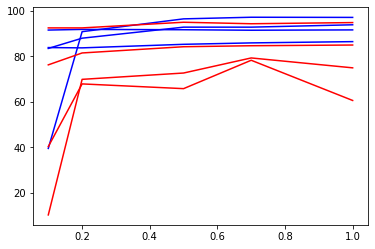

In [11]:
#Plotting data

for dataset in datasets:
    plt.plot(subShareTrainData, sharesReg[dataset],c="blue")
    plt.plot(subShareTrainData, sharesNorm[dataset],c="red")